In [1]:
# Imports + input listing
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

DATA_ROOT = "/kaggle/input/sign-language-digits-dataset"
assert os.path.exists(os.path.join(DATA_ROOT, "X.npy")), "X.npy bulunamadı!"
assert os.path.exists(os.path.join(DATA_ROOT, "Y.npy")), "Y.npy bulunamadı!"
print("✓ Dataset dosyaları bulundu.")


/kaggle/input/sign-language-digits-dataset/Y.npy
/kaggle/input/sign-language-digits-dataset/X.npy
/kaggle/input/sign-language-digits-dataset/Sign-language-digits-dataset/Y.npy
/kaggle/input/sign-language-digits-dataset/Sign-language-digits-dataset/X.npy
✓ Dataset dosyaları bulundu.


# 1) Veri Setini Yükleme & Keşfetme


* Veri seti yüklendi
* Etiketler sayısal formata çevrildi
* Sınıf dağılımı incelendi.


*Her rakamdan 5 örnek görselleştirilerek veri setinin dengeli olduğu ve el işareti görüntülerinin doğru biçimde yüklendiği doğrulandı.*


Görüntü seti şekli: (2062, 64, 64)
Etiket seti şekli: (2062, 10)
Sınıf sayısı: 10
Örnek sınıf dağılımı: [204 205 206 207 206 208 207 206 206 207]
X dtype/range: float32 0.003921568859368563 1.0


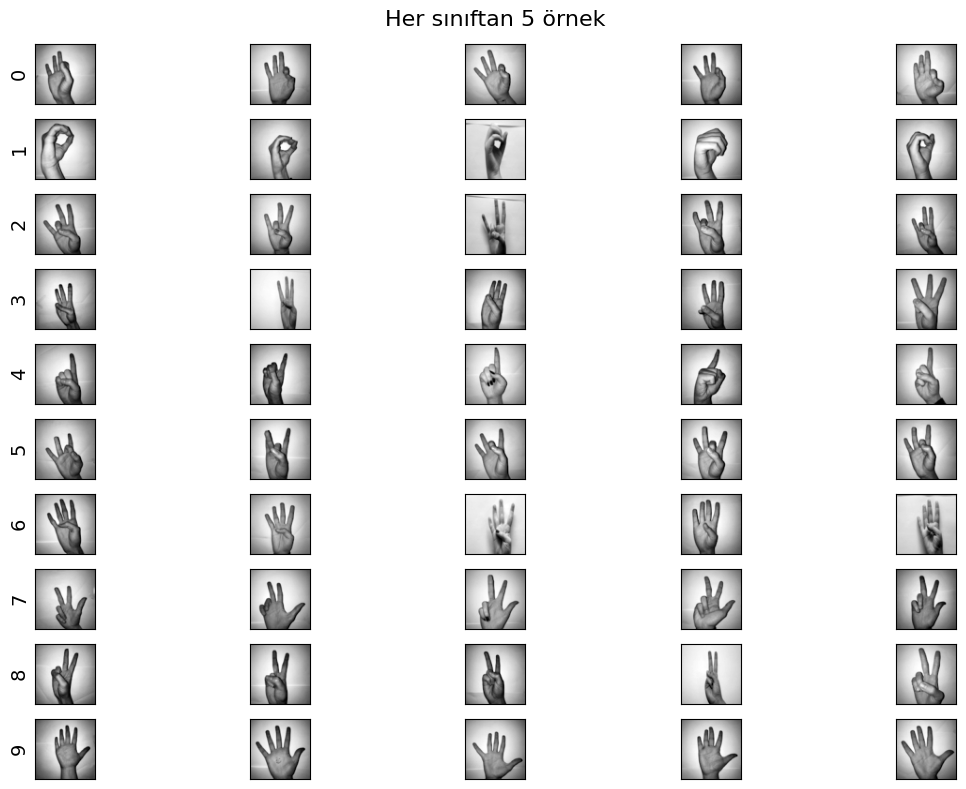

In [2]:
X = np.load(os.path.join(DATA_ROOT, "X.npy"))   
Y = np.load(os.path.join(DATA_ROOT, "Y.npy")) 

print("Görüntü seti şekli:", X.shape)
print("Etiket seti şekli:", Y.shape)

y_labels = np.argmax(Y, axis=1)
print("Sınıf sayısı:", len(np.unique(y_labels)))
print("Örnek sınıf dağılımı:", np.bincount(y_labels))
print("X dtype/range:", X.dtype, float(X.min()), float(X.max()))

class_names = [str(i) for i in range(10)]

plt.figure(figsize=(12, 8))
for digit in range(10):
    indices = np.where(y_labels == digit)[0][:5]
    for i, idx in enumerate(indices):
        plt.subplot(10, 5, digit*5 + i + 1)
        plt.imshow(np.squeeze(X[idx]), cmap="gray")
        plt.xticks([]); plt.yticks([])
        if i == 0:
            plt.ylabel(str(digit), fontsize=14)
plt.suptitle("Her sınıftan 5 örnek", fontsize=16)
plt.tight_layout()
plt.show()


# 2) Veri Ön İşleme

*Veriler normalize edilmiş, kanal boyutu eklenmiş, %80–20 oranında eğitim/test setine ayrılmış ve etiketler one-hot formata çevrilmiştir. Yapılan güvenlik kontrolleri sonucunda verilerin CNN modeline hazır olduğu doğrulanmıştır.*

In [3]:
# Split + Normalize + One-hot
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X = X.astype("float32")
if X.ndim == 3:
    X = np.expand_dims(X, -1)
if X.max() > 1.0:
    X /= 255.0

X_train, X_test, y_train, y_test = train_test_split(
    X, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

NUM_CLASSES = 10
y_train_categorical = to_categorical(y_train, NUM_CLASSES)
y_test_categorical  = to_categorical(y_test,  NUM_CLASSES)

print("Şekiller:", X_train.shape, y_train_categorical.shape, "|", X_test.shape, y_test_categorical.shape)
print("Aralık:", float(X_train.min()), "→", float(X_train.max()))
print("Sınıf dağılımı (train):", np.bincount(y_train))
print("Sınıf dağılımı (test): ", np.bincount(y_test))

# Kontrol
assert X_train.shape[1:] == (64, 64, 1)
assert y_train_categorical.shape[1] == 10
assert np.isfinite(X_train).all() and np.isfinite(X_test).all()
assert (X_train.min() >= 0.0) and (X_train.max() <= 1.0)
print("✓ ADIM 1 kontrolleri geçti.")


2025-09-26 20:51:31.647337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758919891.846184      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758919891.905644      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Şekiller: (1649, 64, 64, 1) (1649, 10) | (413, 64, 64, 1) (413, 10)
Aralık: 0.007843137718737125 → 1.0
Sınıf dağılımı (train): [163 164 165 166 165 166 165 165 165 165]
Sınıf dağılımı (test):  [41 41 41 41 41 42 42 41 41 42]
✓ ADIM 1 kontrolleri geçti.


# 3)Augmented Görsellerin Önizlemesi

*Orijinal ve augmented görüntüler karşılaştırılarak dönüşümlerin doğru çalıştığı ve veri aralığının korunduğu gözlemlenmiştir.*

X_train dtype/range: float32 0.007843137718737125 1.0
X_train shape: (1649, 64, 64, 1)


I0000 00:00:1758919904.031616      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758919904.032263      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


aug_sample dtype/range: <dtype: 'float32'> 0.08438777923583984 1.0061275959014893
aug_sample shape: (4, 64, 64, 1)


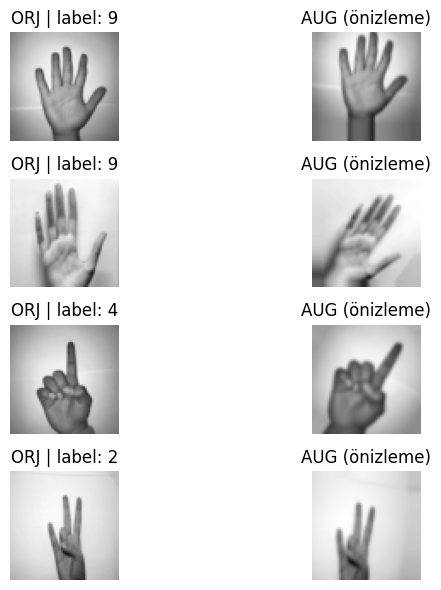

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("X_train dtype/range:", X_train.dtype, float(X_train.min()), float(X_train.max()))
print("X_train shape:", X_train.shape)

aug_preview = keras.Sequential(
    [
        layers.RandomRotation(0.15, fill_mode="nearest"),
        layers.RandomTranslation(0.15, 0.15, fill_mode="nearest"),
        layers.RandomZoom(0.15, fill_mode="nearest"),
        layers.RandomContrast(0.2),
    ],
    name="aug_preview",
)

sample = X_train[:4]
aug_sample = aug_preview(sample, training=True)

print("aug_sample dtype/range:", aug_sample.dtype, float(tf.reduce_min(aug_sample)), float(tf.reduce_max(aug_sample)))
print("aug_sample shape:", aug_sample.shape)

plt.figure(figsize=(8, 6))
for i in range(4):
    plt.subplot(4, 2, 2*i+1); plt.imshow(np.squeeze(sample[i]), cmap="gray", vmin=0, vmax=1); plt.title(f"ORJ | label: {y_train[i]}"); plt.axis("off")
    plt.subplot(4, 2, 2*i+2); plt.imshow(np.squeeze(aug_sample[i]), cmap="gray", vmin=0, vmax=1); plt.title("AUG (önizleme)"); plt.axis("off")
plt.tight_layout(); plt.show(); plt.close()
del aug_sample, sample


# 4) CNN Modeli


*Augmentation bloğu giriş katmanına eklenerek CNN modeli tanımlandı.Üç konvolüsyon bloğu ve bir sınıflandırıcı katmandan oluşan model, Batch Normalization ve Dropout ile düzenlendi. Model Adam optimizatörü ve categorical crossentropy kaybı ile derlenmiş olup eğitim için hazır hale getirildi.*


In [5]:
print("NUM_CLASSES:", NUM_CLASSES)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

INPUT_SHAPE = (64, 64, 1)
augmentation = keras.Sequential([
    layers.RandomRotation(0.10, fill_mode="nearest"),
    layers.RandomTranslation(0.10, 0.10, fill_mode="nearest"),
    layers.RandomZoom(0.10, fill_mode="nearest"),
    layers.RandomContrast(0.15),
], name="augmentation")

inputs = keras.Input(shape=INPUT_SHAPE)
x = augmentation(inputs)

x = layers.Conv2D(32, 3, padding="same", activation=None, kernel_initializer="he_normal")(x)
x = layers.BatchNormalization(momentum=0.9, epsilon=1e-3)(x)
x = layers.ReLU()(x)
x = layers.Conv2D(32, 3, padding="same", activation=None, kernel_initializer="he_normal")(x)
x = layers.BatchNormalization(momentum=0.9, epsilon=1e-3)(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.10)(x)

x = layers.Conv2D(64, 3, padding="same", activation=None, kernel_initializer="he_normal")(x)
x = layers.BatchNormalization(momentum=0.9, epsilon=1e-3)(x)
x = layers.ReLU()(x)
x = layers.Conv2D(64, 3, padding="same", activation=None, kernel_initializer="he_normal")(x)
x = layers.BatchNormalization(momentum=0.9, epsilon=1e-3)(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.20)(x)

x = layers.Conv2D(128, 3, padding="same", activation=None, kernel_initializer="he_normal")(x)
x = layers.BatchNormalization(momentum=0.9, epsilon=1e-3)(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.30)(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation=None, kernel_initializer="he_normal")(x)
x = layers.BatchNormalization(momentum=0.9, epsilon=1e-3)(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.40)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs, name="digits_cnn_aug_bn")
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()
assert model.input_shape[1:] == (64, 64, 1)


NUM_CLASSES: 10
Train shape: (1649, 64, 64, 1) Test shape: (413, 64, 64, 1)


Model: "digits_cnn_aug_bn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,241,130 (8.55 MB)

 Trainable params: 2,239,978 (8.54 MB)

 Non-trainable params: 1,152 (4.50 KB)

# 5) Ezber Testi/Overfitting Test 

*Modelin kapasitesini doğrulamak için 256 örneklik küçük bir alt küme üzerinde ezber testi yapılmıştır.CNN modeli bu veriyi %95’in üzerinde başarıyla öğrenmiş böylece modelin yeterli kapasiteye sahip olduğu doğrulanmıştır.*

In [6]:
idx = np.random.choice(len(X_train), 256, replace=False)
X_small = X_train[idx]
y_small = y_train_categorical[idx]

def make_tiny_plain(input_shape=(64,64,1), num_classes=10):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    m = keras.Model(inputs, outputs)
    m.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy", metrics=["accuracy"])
    return m

plain = make_tiny_plain()
h3 = plain.fit(X_small, y_small, validation_data=(X_small, y_small),
               epochs=25, batch_size=32, shuffle=False, verbose=0)

train_acc = h3.history["accuracy"][-1]
val_acc   = h3.history["val_accuracy"][-1]
print(f"Tiny plain -> train_acc: {train_acc:.3f} | val_acc: {val_acc:.3f}")

probs = plain.predict(X_small, verbose=0)
pred  = probs.argmax(axis=1)
true  = y_small.argmax(axis=1)
manual_acc = (pred == true).mean()
print("Manual acc on same small set:", manual_acc)

assert train_acc >= 0.95 and val_acc >= 0.95 and manual_acc >= 0.95, "Ezber testi başarısız!"
print("✓ ADIM 3 ezber testi geçti.")
del plain, X_small, y_small, probs, pred, true


I0000 00:00:1758919908.772924      64 service.cc:148] XLA service 0x3ce5f7a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758919908.773600      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758919908.773617      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758919909.009906      64 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758919911.284594      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Tiny plain -> train_acc: 0.980 | val_acc: 0.988
Manual acc on same small set: 0.98828125
✓ ADIM 3 ezber testi geçti.


# 6) Modelin Eğitilmesi

*EarlyStopping ve ReduceLROnPlateau callbackleri kullanılarak eğitim süreci optimize edildi ve overfitting riski azaltıldı.*

In [7]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5),
]

history = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=40,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/40


E0000 00:00:1758919922.110515      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/digits_cnn_aug_bn_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.1095 - loss: 2.8187 - val_accuracy: 0.1453 - val_loss: 2.1300 - learning_rate: 1.0000e-04
Epoch 2/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.2033 - loss: 2.4230 - val_accuracy: 0.4504 - val_loss: 1.5819 - learning_rate: 1.0000e-04
Epoch 3/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.2654 - loss: 2.1767 - val_accuracy: 0.5908 - val_loss: 1.2994 - learning_rate: 1.0000e-04
Epoch 4/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3076 - loss: 2.0349 - val_accuracy: 0.6271 - val_loss: 1.1407 - learning_rate: 1.0000e-04
Epoch 5/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3427 - loss: 1.9059 - val_accuracy: 0.6949 - val_loss: 0.9951 - learning_rate: 1.0000e-04
Epoch 6/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4021 - loss: 1.6910 - val_accuracy: 0.7530 - val_loss: 0.8740 - learning_rate: 1.0000e-04
Epoch 7/40
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4325 - loss: 1.

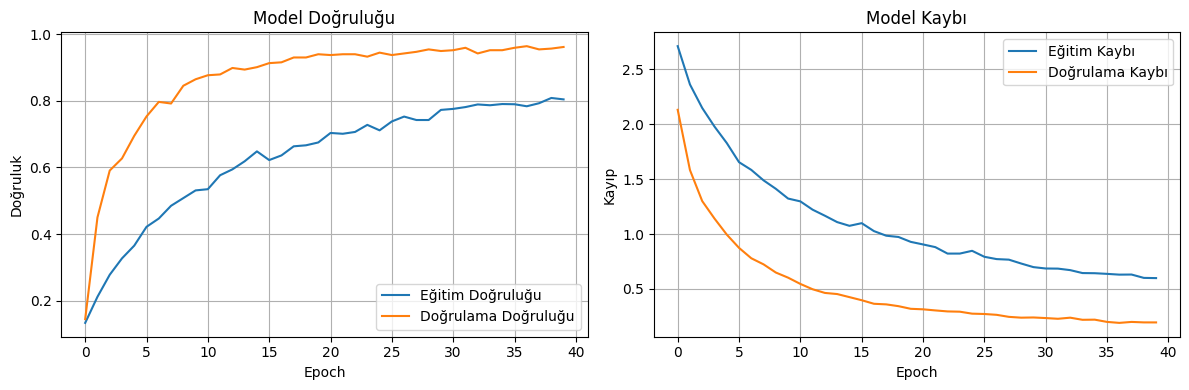

In [8]:
plt.figure(figsize=(12,4))

#Doğruluk
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Eğitim Doğruluğu")
plt.plot(history.history["val_accuracy"], label="Doğrulama Doğruluğu")
plt.title("Model Doğruluğu")
plt.xlabel("Epoch")
plt.ylabel("Doğruluk")
plt.legend()
plt.grid(True)

#Kayıp
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Eğitim Kaybı")
plt.plot(history.history["val_loss"], label="Doğrulama Kaybı")
plt.title("Model Kaybı")
plt.xlabel("Epoch")
plt.ylabel("Kayıp")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# 7) Model Değerlendirme

Test accuracy: 0.9637 | Test loss: 0.1916
              precision    recall  f1-score   support

           0     0.9756    0.9756    0.9756        41
           1     1.0000    1.0000    1.0000        41
           2     0.9487    0.9024    0.9250        41
           3     0.9318    1.0000    0.9647        41
           4     1.0000    1.0000    1.0000        41
           5     0.9524    0.9524    0.9524        42
           6     0.9524    0.9524    0.9524        42
           7     1.0000    0.8780    0.9351        41
           8     0.8913    1.0000    0.9425        41
           9     1.0000    0.9762    0.9880        42

    accuracy                         0.9637       413
   macro avg     0.9652    0.9637    0.9636       413
weighted avg     0.9652    0.9637    0.9636       413



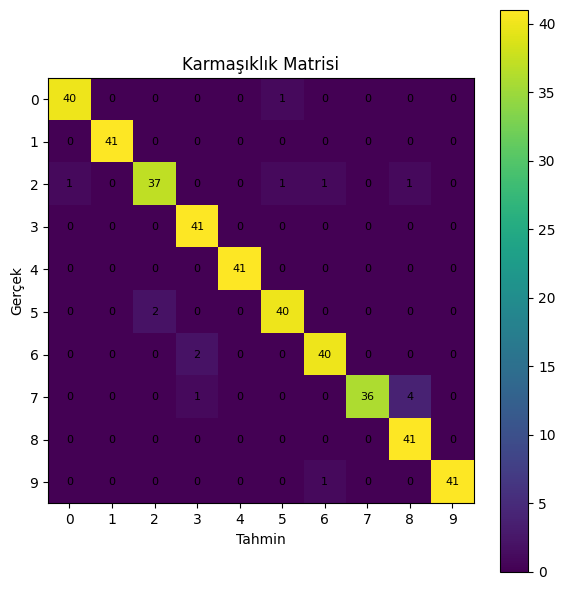

Kaydedildi: /kaggle/working/digits_cnn_aug_bn.keras | /kaggle/working/train_history.csv


In [9]:
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_acc = model.evaluate(X_test, y_test_categorical, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

y_true = y_test
y_pred = model.predict(X_test, batch_size=64, verbose=0).argmax(1)
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Karmaşıklık Matrisi"); plt.xlabel("Tahmin"); plt.ylabel("Gerçek")
plt.colorbar()
ticks = range(10)
plt.xticks(ticks, ticks); plt.yticks(ticks, ticks)
for i in range(10):
    for j in range(10):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)
plt.tight_layout(); plt.show()

model.save("/kaggle/working/digits_cnn_aug_bn.keras")
pd.DataFrame(history.history).to_csv("/kaggle/working/train_history.csv", index=False)
print("Kaydedildi: /kaggle/working/digits_cnn_aug_bn.keras | /kaggle/working/train_history.csv")


# 7.2)GRAD-CAM

In [10]:
#GRAD-CAM 
try:
    import cv2
    _HAS_CV2 = True
except Exception:
    _HAS_CV2 = False
    import matplotlib.cm as cm

def _find_last_conv_layer(model: tf.keras.Model) -> str:
    for layer in reversed(model.layers):
        if isinstance(layer, (tf.keras.layers.Conv2D,
                              tf.keras.layers.SeparableConv2D,
                              tf.keras.layers.DepthwiseConv2D)):
            return layer.name
    raise ValueError("Modelde Conv2D tabanlı bir katman bulunamadı.")

def _normalize_cam(cam: np.ndarray) -> np.ndarray:
    cam = np.maximum(cam, 0)
    cam -= cam.min()
    cam = cam / (cam.max() + 1e-8)
    return cam

def _overlay(img_rgb: np.ndarray, cam: np.ndarray, alpha: float = 0.35) -> np.ndarray:
    cam_u8 = (cam * 255).astype("uint8")
    if _HAS_CV2:
        heatmap = cv2.applyColorMap(cam_u8, cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    else:
        heatmap = (cm.get_cmap('jet')(cam)[:, :, :3] * 255).astype("uint8")
    overlay = (alpha * heatmap + (1 - alpha) * img_rgb).astype("uint8")
    return overlay

def to_model_input(img_np, input_shape, scale=True):
    H, W, C = input_shape
    try:
        import cv2
        resized = cv2.resize(img_np, (W, H))
    except Exception:
        from PIL import Image
        resized = np.array(Image.fromarray(img_np).resize((W, H)))
    if C == 1:
        if resized.ndim == 3:
            resized = np.mean(resized, axis=2).astype(resized.dtype)
        resized = resized[..., None]
    else:
        if resized.ndim == 2:
            resized = np.repeat(resized[..., None], 3, axis=2)
    x = resized.astype("float32")
    if scale:
        x = x / 255.0
    x = np.expand_dims(x, axis=0)
    return x, resized

def grad_cam(model: tf.keras.Model, x: np.ndarray,
             class_index: int | None = None,
             last_conv_name: str | None = None) -> np.ndarray:
    if last_conv_name is None:
        last_conv_name = _find_last_conv_layer(model)
    conv_layer = model.get_layer(last_conv_name)

    grad_model = tf.keras.Model([model.inputs], [conv_layer.output, model.output])
    def _forward(_x):
        try:
            return grad_model(_x, training=False)
        except Exception:
            return grad_model([_x], training=False)

    with tf.GradientTape() as tape:
        conv_out, preds = _forward(x)
        if class_index is None:
            class_index = tf.argmax(preds[0])
        loss = preds[:, class_index]

    grads = tape.gradient(loss, conv_out)        
    pooled = tf.reduce_mean(grads, axis=(0,1,2))   
    conv_out = conv_out[0]                        
    cam = tf.reduce_sum(conv_out * pooled, axis=-1).numpy() 
    return _normalize_cam(cam)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_5']]
Received: inputs=Tensor(shape=(1, 64, 64, 1))
  warnings.warn(msg)


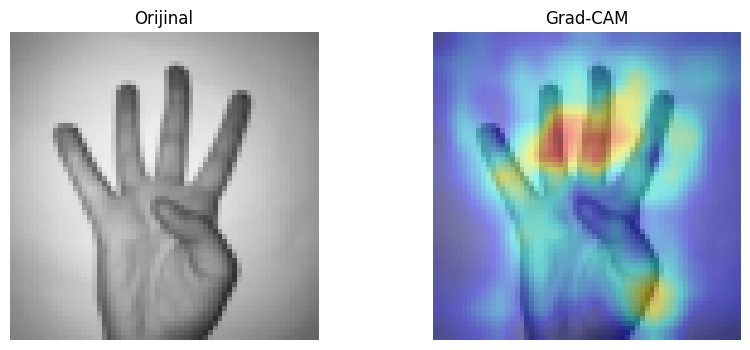

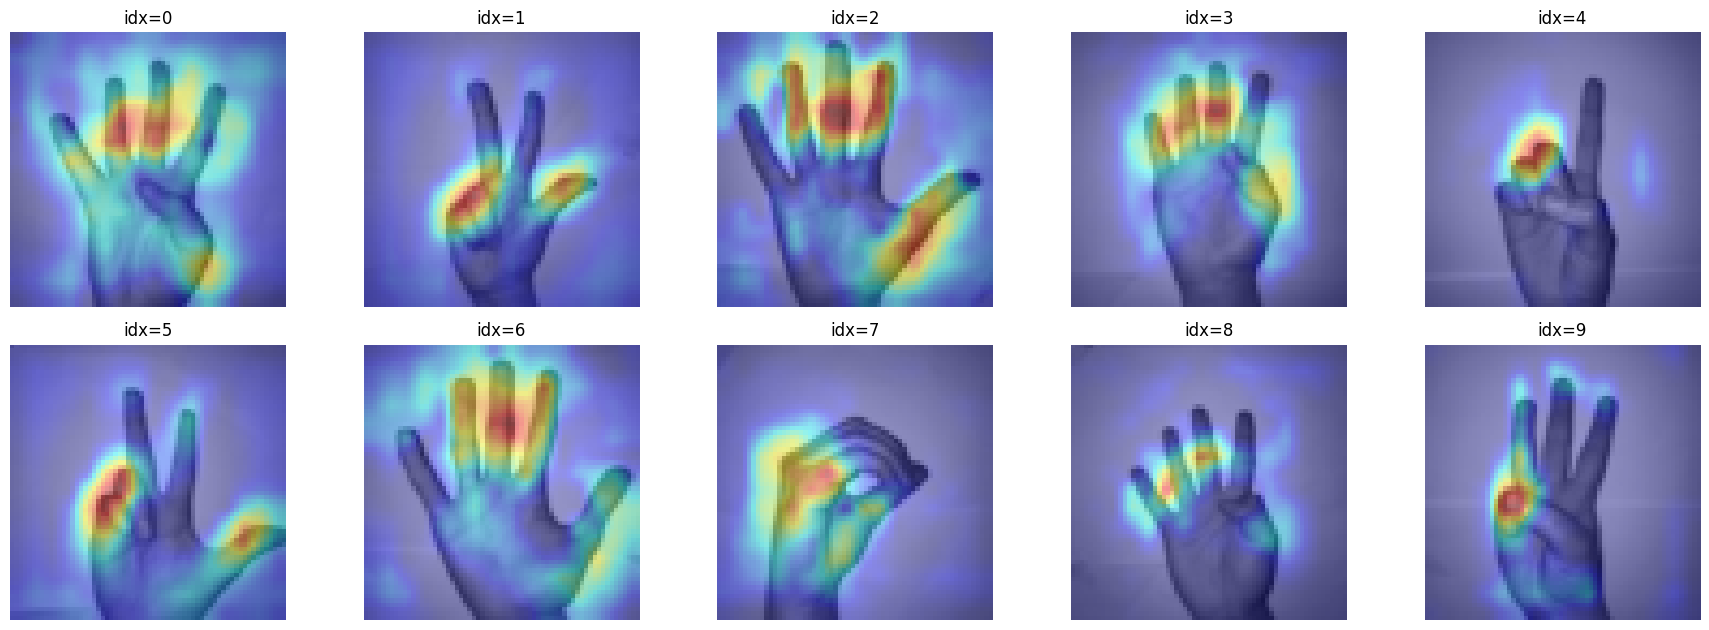

In [11]:
#Tek örnek için Grad-CAM
i = 0  
img_raw = X_test[i]
img_np  = (img_raw * (255.0 if img_raw.max() <= 1.0 else 1.0)).astype("uint8")

input_shape = model.input_shape[1:4] 
x, vis = to_model_input(img_np, input_shape, scale=True) 
cam = grad_cam(model, x, class_index=None, last_conv_name=None)


if vis.ndim == 2:      vis_rgb = np.repeat(vis[..., None], 3, axis=2)
elif vis.shape[-1]==1: vis_rgb = np.repeat(vis, 3, axis=2)
else:                  vis_rgb = vis
H0, W0 = vis_rgb.shape[:2]
try:
    import cv2
    cam_resized = cv2.resize(cam, (W0, H0), interpolation=cv2.INTER_LINEAR)
except Exception:
    from PIL import Image
    cam_resized = np.array(Image.fromarray((cam*255).astype("uint8")).resize((W0, H0))) / 255.0

overlay = _overlay(vis_rgb.astype("uint8"), cam_resized, alpha=0.40)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title("Orijinal"); plt.imshow(vis_rgb, cmap=None); plt.axis('off')
plt.subplot(1,2,2); plt.title("Grad-CAM"); plt.imshow(overlay); plt.axis('off')
plt.show()


rows, cols = 2, 5
start = 0
fig, axes = plt.subplots(rows, cols, figsize=(3.6*cols, 3.2*rows))
for k in range(rows*cols):
    idx = start + k
    img_raw = X_test[idx]
    img_np  = (img_raw * (255.0 if img_raw.max() <= 1.0 else 1.0)).astype("uint8")
    x, vis  = to_model_input(img_np, input_shape, scale=True)
    cam     = grad_cam(model, x)

    if vis.ndim == 2:      vis_rgb = np.repeat(vis[..., None], 3, axis=2)
    elif vis.shape[-1]==1: vis_rgb = np.repeat(vis, 3, axis=2)
    else:                  vis_rgb = vis
    H0, W0 = vis_rgb.shape[:2]
    try:
        cam_resized = cv2.resize(cam, (W0, H0), interpolation=cv2.INTER_LINEAR)
    except Exception:
        from PIL import Image
        cam_resized = np.array(Image.fromarray((cam*255).astype("uint8")).resize((W0, H0))) / 255.0

    overlay = _overlay(vis_rgb.astype("uint8"), cam_resized, alpha=0.40)
    ax = axes[k//cols, k%cols]
    ax.imshow(overlay); ax.set_title(f"idx={idx}"); ax.axis('off')

plt.tight_layout(); plt.show()


# 8) Transfer Learning

*VGG16 tabanlı transfer öğrenme modeli önceden ImageNet üzerinde öğrenilmiş özellikleri kullanarak işaret dili rakamları sınıflandırma görevinde yüksek doğruluk sağlandı. Bu yöntemle küçük veri setlerinde sıfırdan eğitilen CNN modellerine göre daha hızlı yakınsama ve daha iyi genelleme performansı göstermiştir.*

In [12]:
#VGG16 için X_train/X_test'i hazırlama
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

if "X_train" not in globals():
    from sklearn.model_selection import train_test_split
    DATA_ROOT = "/kaggle/input/sign-language-digits-dataset"
    X = np.load(os.path.join(DATA_ROOT, "X.npy")).astype("float32")
    Y = np.load(os.path.join(DATA_ROOT, "Y.npy"))
    y_labels = np.argmax(Y, axis=1)
    if X.ndim == 3: X = np.expand_dims(X, -1)
    if X.max() > 1.0: X /= 255.0
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_labels, test_size=0.2, random_state=42, stratify=y_labels
    )
    NUM_CLASSES = 10
    y_train_categorical = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test_categorical  = keras.utils.to_categorical(y_test,  NUM_CLASSES)

#VGG16 için RGB + 128x128 + preprocess
IMG_SIZE = 128
def make_vgg_arrays(X):
    x = tf.convert_to_tensor(X)                            
    if x.shape[-1] == 1:
        x = tf.image.grayscale_to_rgb(x)                        
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE), antialias=True) 
    x = x * 255.0                                                
    x = vgg_preprocess(x)                                       
    return x.numpy().astype("float32")

X_train_vgg = make_vgg_arrays(X_train)
X_test_vgg  = make_vgg_arrays(X_test)

print("VGG arrays:", X_train_vgg.shape, X_test_vgg.shape)


VGG arrays: (1649, 128, 128, 3) (413, 128, 128, 3)


In [13]:
#VGG16 tabanlı transfer modeli
base_model = keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

for layer in base_model.layers:
    layer.trainable = False

transfer_model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
], name="vgg16_transfer")

transfer_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

transfer_model.summary()

tl_callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
]

history_transfer = transfer_model.fit(
    X_train_vgg, y_train_categorical,
    validation_data=(X_test_vgg, y_test_categorical),
    epochs=20,
    batch_size=32,
    shuffle=True,
    callbacks=tl_callbacks,
    verbose=1
)

test_loss_transfer, test_accuracy_transfer = transfer_model.evaluate(X_test_vgg, y_test_categorical, verbose=0)
print(f"Transfer Learning Test Doğruluğu: {test_accuracy_transfer:.4f}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 297ms/step - accuracy: 0.1155 - loss: 6.6071 - val_accuracy: 0.3196 - val_loss: 2.1587 - learning_rate: 1.0000e-04
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.1989 - loss: 4.2606 - val_accuracy: 0.4867 - val_loss: 1.5472 - learning_rate: 1.0000e-04
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.3103 - loss: 3.0486 - val_accuracy: 0.5884 - val_loss: 1.2356 - learning_rate: 1.0000e-04
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.4004 - loss: 2.3268 - val_accuracy: 0.6489 - val_loss: 1.0356 - learning_rate: 1.0000e-04
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.4553 - loss: 1.9531 - val_accuracy: 0.6901 - val_loss: 0.9117 - learning_rate: 1.0000e-04
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.5190 - loss: 1.5252 - val_accuracy: 0.7337 - val_loss: 0.8294 - learning_rate: 1.0000e-04
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.557

*Transfer learning sonrası VGG16 tabanında block5 katmanları eğitime açılarak fine-tuning yapılmıştır.Küçük bir öğrenme oranı ile yapılan bu ince ayar sayesinde model işaret dili rakam datasetine daha iyi uyum sağlamış ve test doğruluğu artmıştır.*

In [14]:
#Fine-tuning
unfreeze = False
for layer in base_model.layers:
    if "block5" in layer.name:
        unfreeze = True
    layer.trainable = unfreeze  

transfer_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

transfer_model.summary()

ft_callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
]

history_ft = transfer_model.fit(
    X_train_vgg, y_train_categorical,
    validation_data=(X_test_vgg, y_test_categorical),
    epochs=10,
    batch_size=32,
    shuffle=True,
    callbacks=ft_callbacks,
    verbose=1
)

test_loss_ft, test_acc_ft = transfer_model.evaluate(X_test_vgg, y_test_categorical, verbose=0)
print(f"Fine-tuned Test Doğruluğu: {test_acc_ft:.4f}")


final_tl_acc = float(test_acc_ft)   #fine-tuned sonucu


Model: "vgg16_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 7,213,322 (27.52 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - accuracy: 0.8317 - loss: 0.5216 - val_accuracy: 0.9153 - val_loss: 0.2696 - learning_rate: 1.0000e-05
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.8910 - loss: 0.2940 - val_accuracy: 0.9274 - val_loss: 0.2048 - learning_rate: 1.0000e-05
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9329 - loss: 0.1960 - val_accuracy: 0.9516 - val_loss: 0.1639 - learning_rate: 1.0000e-05
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9504 - loss: 0.1401 - val_accuracy: 0.9661 - val_loss: 0.1138 - learning_rate: 1.0000e-05
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9650 - loss: 0.1041 - val_accuracy: 0.9661 - val_loss: 0.1127 - learning_rate: 1.0000e-05
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9722 - loss: 0.0969 - val_accuracy: 0.9661 - val_loss: 0.0990 - learning_rate: 1.0000e-05
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy:

In [15]:
transfer_model.save("/kaggle/working/vgg16_transfer_ft.keras")
print("✓ Kaydedildi: /kaggle/working/vgg16_transfer_ft.keras")


✓ Kaydedildi: /kaggle/working/vgg16_transfer_ft.keras


# 9) Veri Görselleştirme ve Model Karşılaştırması

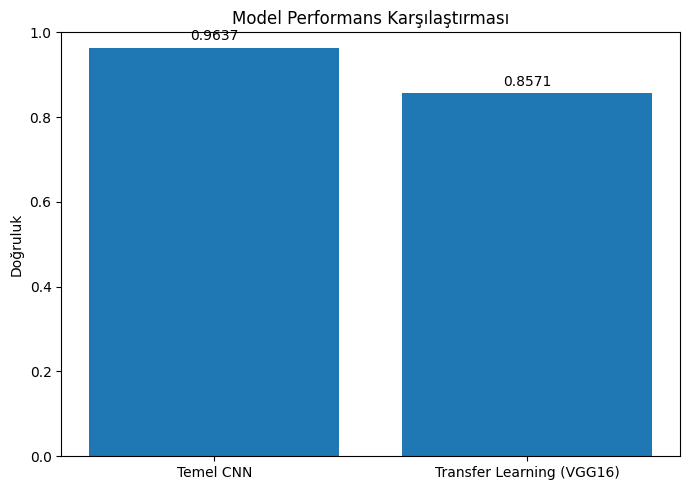

In [16]:
#CNN Modelimiz ve Transfer Learning doğruluk karşılaştırması
if "test_acc" not in globals():
    _loss_base, test_acc = model.evaluate(X_test, y_test_categorical, verbose=0)

#Transfer model 
if "test_accuracy_transfer" not in globals():
    _loss_tl, test_accuracy_transfer = transfer_model.evaluate(X_test_vgg, y_test_categorical, verbose=0)

models = ["Temel CNN", "Transfer Learning (VGG16)"]
accuracies = [float(test_acc), float(test_accuracy_transfer)]

plt.figure(figsize=(7,5))
bars = plt.bar(models, accuracies)  
plt.title("Model Performans Karşılaştırması")
plt.ylabel("Doğruluk")
plt.ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.01,
             f"{acc:.4f}",
             ha="center", va="bottom")
plt.tight_layout()
plt.show()


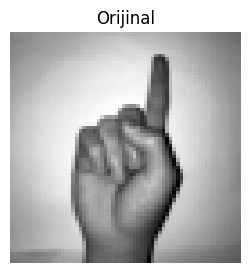

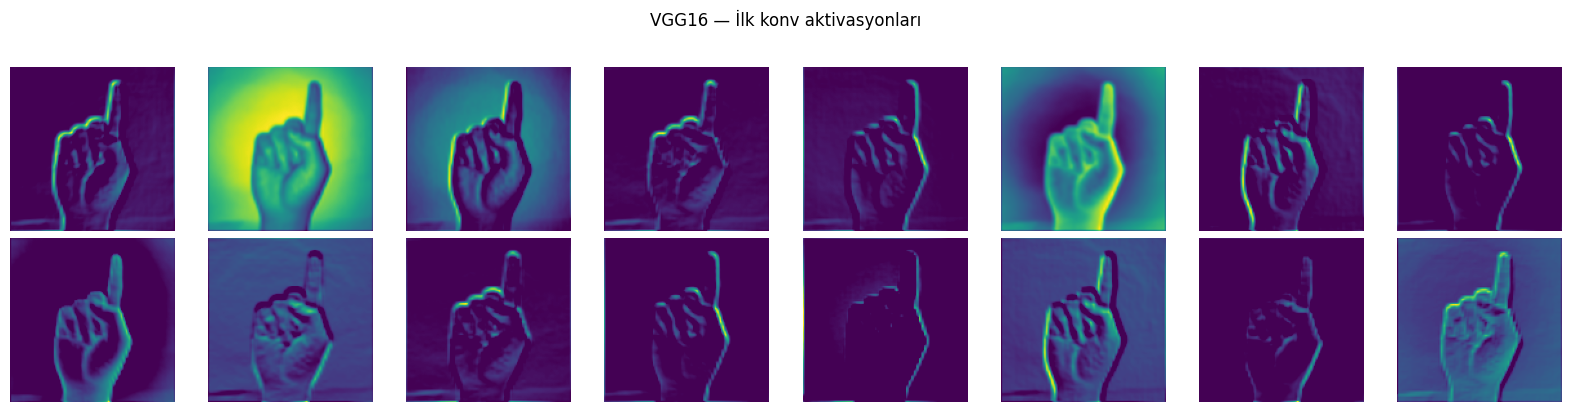

In [17]:
#VGG16 — Güvenli aktivasyon görselleştirme
idx = 10        #Test örneği
IMG_SIZE = 128  #VGG16 giriş boyutu

#Base model seçimi
bm = None
if "base_model" in globals():
    bm = base_model
elif "transfer_model" in globals():
    if hasattr(transfer_model, "layers") and len(transfer_model.layers) > 0:
        if isinstance(transfer_model.layers[0], keras.Model):
            bm = transfer_model.layers[0]

if bm is None:
    print("[Bilgi] base_model bulunamadı; lütfen önce TL-2 hücresini çalıştır.")
else:
    if "X_test_vgg" not in globals():
        from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
        xt = tf.convert_to_tensor(X_test)
        if xt.shape[-1] == 1:
            xt = tf.image.grayscale_to_rgb(xt)
        xt = tf.image.resize(xt, (IMG_SIZE, IMG_SIZE), antialias=True)
        xt = xt * 255.0
        X_test_vgg = vgg_preprocess(xt).numpy().astype("float32")
    plt.figure(figsize=(3,3))
    plt.imshow(np.squeeze(X_test[idx]), cmap="gray")
    plt.title("Orijinal")
    plt.axis("off")
    plt.show()
    try:
        target = bm.get_layer("block1_conv1").output
    except Exception:
        vgg_conv_layers = [l for l in bm.layers if isinstance(l, layers.Conv2D)]
        if not vgg_conv_layers:
            print("[Uyarı] VGG tabanında Conv2D katmanı bulunamadı; görselleştirme atlandı.")
            target = None
        else:
            target = vgg_conv_layers[0].output

    if target is not None:
        vgg_act_model = keras.Model(inputs=bm.input, outputs=target)
        acts = vgg_act_model.predict(X_test_vgg[idx:idx+1], verbose=0)

        n_show = min(16, acts.shape[-1]) 
        n_cols = 8
        n_rows = int(np.ceil(n_show / n_cols))
        plt.figure(figsize=(n_cols*2, n_rows*2))
        plt.suptitle("VGG16 — İlk konv aktivasyonları", y=1.02)
        for i in range(n_show):
            a = acts[0, :, :, i]
            plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(a, cmap="viridis")
            plt.axis("off")
        plt.tight_layout()
        plt.show()


# 10) Model İyileştirme Teknikleri

In [18]:
# OPT-SETUP:Aynı mimariyi her denemede sıfırdan kurmak için bir factory fonksiyonu
tf.keras.utils.set_random_seed(42)

def create_cnn_model(input_shape=(64,64,1), num_classes=10, use_aug=False):
    inputs = keras.Input(shape=input_shape)

    x = inputs
    if use_aug:
        aug = keras.Sequential([
            layers.RandomRotation(0.10, fill_mode="nearest"),
            layers.RandomTranslation(0.10, 0.10, fill_mode="nearest"),
            layers.RandomZoom(0.10, fill_mode="nearest"),
            layers.RandomContrast(0.15),
        ], name="augmentation")
        x = aug(x)

    x = layers.Conv2D(32, 3, padding="same", activation=None, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-3)(x); x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, padding="same", activation=None, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-3)(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x); x = layers.Dropout(0.10)(x)

    x = layers.Conv2D(64, 3, padding="same", activation=None, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-3)(x); x = layers.ReLU()(x)
    x = layers.Conv2D(64, 3, padding="same", activation=None, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-3)(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x); x = layers.Dropout(0.20)(x)

    x = layers.Conv2D(128, 3, padding="same", activation=None, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-3)(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x); x = layers.Dropout(0.30)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation=None, kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-3)(x); x = layers.ReLU()(x)
    x = layers.Dropout(0.40)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="cnn_for_optimizer_benchmark")
    return model

assert "X_train" in globals() and "y_train_categorical" in globals(), "Önce ADIM-1 (split+normalize+one-hot) hücresini çalıştır."



[Adam] ile eğitim...
Adam Test Doğruluğu: 0.9661

[RMSprop] ile eğitim...
RMSprop Test Doğruluğu: 0.9734

[SGD(m)] ile eğitim...
SGD(m) Test Doğruluğu: 0.9661

[Nadam] ile eğitim...
Nadam Test Doğruluğu: 0.9516

[AdamW] ile eğitim...
AdamW Test Doğruluğu: 0.9661


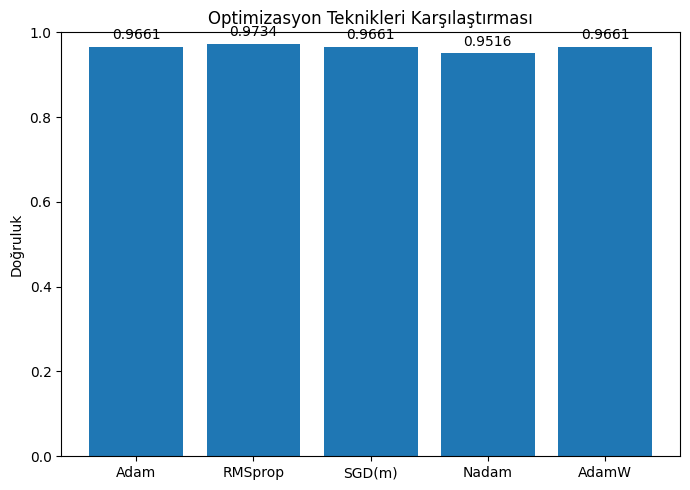

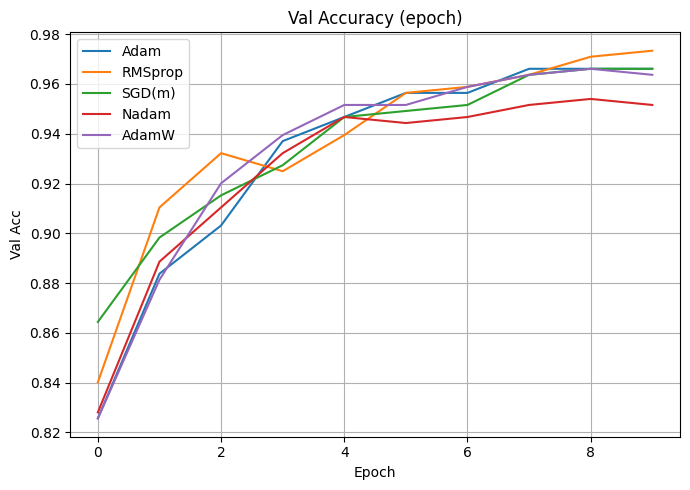

In [19]:
from collections import OrderedDict
EPOCHS = 10
BATCH = 32

optimizers = OrderedDict({
    "Adam":    keras.optimizers.Adam(learning_rate=1e-3),
    "RMSprop": keras.optimizers.RMSprop(learning_rate=1e-3),
    "SGD(m)":  keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=False),
    "Nadam":   keras.optimizers.Nadam(learning_rate=1e-3),
    "AdamW":   keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
})

results = {}
histories = {}

for opt_name, optimizer in optimizers.items():
    print(f"\n[{opt_name}] ile eğitim...")
    model_bench = create_cnn_model(use_aug=False)  #karşılaştırmada augment kapalı 
    model_bench.compile(optimizer=optimizer,
                        loss="categorical_crossentropy",
                        metrics=["accuracy"])
    cbs = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5),
    ]

    h = model_bench.fit(
        X_train, y_train_categorical,
        epochs=EPOCHS,
        batch_size=BATCH,
        validation_data=(X_test, y_test_categorical),
        verbose=0,
        callbacks=cbs,
        shuffle=True,
    )
    histories[opt_name] = h.history

    test_loss, test_acc = model_bench.evaluate(X_test, y_test_categorical, verbose=0)
    results[opt_name] = float(test_acc)
    print(f"{opt_name} Test Doğruluğu: {test_acc:.4f}")

plt.figure(figsize=(7,5))
bars = plt.bar(list(results.keys()), list(results.values()))
plt.title("Optimizasyon Teknikleri Karşılaştırması")
plt.ylabel("Doğruluk")
plt.ylim(0, 1)
for bar, acc in zip(bars, results.values()):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01,
             f"{acc:.4f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
for name, h in histories.items():
    plt.plot(h["val_accuracy"], label=name)
plt.title("Val Accuracy (epoch)")
plt.xlabel("Epoch"); plt.ylabel("Val Acc"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()


# 11) Sonuçlar ve Değerlendirme

In [20]:
def _ensure_vgg_test_arrays():
    global X_test_vgg
    if "X_test_vgg" in globals():
        return True
    try:
        from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
        IMG_SIZE = 128 
        x = tf.convert_to_tensor(X_test)
        if x.shape[-1] == 1:
            x = tf.image.grayscale_to_rgb(x)
        x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE), antialias=True)
        x = x * 255.0
        X_test_vgg = vgg_preprocess(x).numpy().astype("float32")
        return True
    except Exception as e:
        print("[Uyarı] X_test_vgg hazırlanamadı:", e)
        return False

#CNN doğruluğu 
base_acc = None
if "test_acc" in globals():
    base_acc = float(test_acc)
elif "model" in globals():
    try:
        _loss_base, _acc_base = model.evaluate(X_test, y_test_categorical, verbose=0)
        base_acc = float(_acc_base)
    except Exception as e:
        print("[Uyarı] Temel CNN değerlendirmesi yapılamadı:", e)

#Transfer Learning doğruluğu
tl_acc = None
if "final_tl_acc" in globals():
    tl_acc = float(final_tl_acc)
elif "test_acc_ft" in globals():
    tl_acc = float(test_acc_ft)
elif "test_accuracy_transfer" in globals():
    tl_acc = float(test_accuracy_transfer)
elif "transfer_model" in globals():
    if _ensure_vgg_test_arrays():
        try:
            _loss_tl, _acc_tl = transfer_model.evaluate(X_test_vgg, y_test_categorical, verbose=0)
            tl_acc = float(_acc_tl)
        except Exception as e:
            print("[Uyarı] Transfer modeli değerlendirmesi yapılamadı:", e)

#En iyi optimizer
best_name, best_value = None, None
if "results" in globals() and isinstance(results, dict) and len(results) > 0:
    best_name = max(results, key=results.get)
    best_value = float(results[best_name])

def fmt(x):
    return f"{x:.4f}" if isinstance(x, (int, float, np.floating)) else "—"

title = "Sign Language Digits — SONUÇ ÖZETİ"
line = "=" * len(title)
print(line)
print(title)
print(line)
print(f"Temel CNN Model Doğruluğu: {fmt(base_acc)}")
print(f"Transfer Learning Model Doğruluğu: {fmt(tl_acc)}")
if best_name is not None:
    print(f"En iyi optimizer: {best_name} ({fmt(best_value)})")
else:
    print("En iyi optimizer: —")
print(line)



Sign Language Digits — SONUÇ ÖZETİ
Temel CNN Model Doğruluğu: 0.9661
Transfer Learning Model Doğruluğu: 0.9685
En iyi optimizer: RMSprop (0.9734)
